# Eden Misan  and Hadar Yakir 

## https://github.com/edenmisan/apartments_project

### Reading the data

In [62]:
import pandas as pd
import numpy as np

# קריאת הקובץ
file_path = "train.csv"
df = pd.read_csv(file_path)

df

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
0,דירה,הצפון הישן החלק המרכזי,"מהר""ל 25",3.0,2,71,NaN,0.0,12.0,467.0,...,1,0,0,1,1,0,0,10150.0,6.0,1005.00
1,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 35,3.0,1,70,NaN,0.0,12.0,240.0,...,1,0,1,0,1,0,0,6600.0,3.0,253.00
2,דירה,הצפון הישן החלק המרכזי,וורמיזה 5,2.5,1,65,NaN,NaN,12.0,400.0,...,1,1,0,0,1,0,1,9000.0,8.0,740.00
3,דירה,הצפון הישן החלק המרכזי,עמנואל הרומי 30,2.0,3,40,NaN,0.0,12.0,100.0,...,0,0,0,0,0,0,0,5800.0,2.0,1206.00
4,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 50,3.0,1,70,NaN,0.0,11.0,250.0,...,1,0,1,0,0,0,1,7700.0,5.0,255.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,גג/פנטהאוז,מונטיפיורי,יהודית 33,2.5,5,55,0.0,0.0,12.0,500.0,...,1,0,0,1,1,0,1,6300.0,3.0,1.69
784,דירה,הצפון הישן החלק הדרום מערבי,בן יהודה 88,3.0,2,90,0.0,0.0,12.0,500.0,...,1,0,0,0,0,1,1,15000.0,4.0,1.11
785,דירה,הצפון הישן החלק הדרום מערבי,רופין 22,2.0,3,80,0.0,0.0,12.0,450.0,...,1,0,0,0,1,0,1,8000.0,5.0,1.57
786,סטודיו/לופט,מונטיפיורי,שדרות יהודית 27,1.0,3,30,0.0,0.0,6.0,180.0,...,1,0,0,0,0,1,1,4000.0,0.0,3.21


In [63]:
def prepare_data(df,mode="train"):
    
    global street_price_avg, overall_avg, type_avg_price
    import pandas as pd
    import numpy as np
    import re
    from sklearn.preprocessing import OneHotEncoder
    global encoder
    global room_neighborhood_avg_price,address_average_price # הוסיפי שורת global
    
    if mode == "train":

        # העברת עמודת price לסוף
        if "price" in df.columns:
            price_col = df.pop("price")
            df["price"] = price_col.astype("float64")

        # מחיקת שורות שבהן price הוא NaN
        df = df.dropna(subset=["price"])

        #  הסרת שורות שבהן המחיר נמוך מ- 2000 לאחר הסתכלות על אותן שורות, ראינו שמדובר בשורות לא רלוונטיות כגון חניות ועוד.
        df = df[df["price"]>= 2000]

        # הסרת שורות שבהן המחיר גבוה מ- 60,000 הסתכלנו על השרות והמחיר אינו תאם את הנתונים ולכן החלטנו להוריד את אותן שורות               
        df=df[df["price"] <= 60000]

    #  הסרת שורות עם ערך חסר בעמודת של השכונה(לאחר בדיקה מדובר בפירסומות ולא בדירות) 
    df = df.dropna(subset=['neighborhood'])

    # ניקוי טקסט — הסרה של שורות מסוג "כללי" שכוללות "משרד" או "חנות" בתיאור
    mask_general = df["property_type"] == "כללי"
    mask_contains_keywords = df["description"].str.contains("משרד|חנות", na=False)

    # שילוב התנאים ומחיקה
    df = df[~(mask_general & mask_contains_keywords)]

    # ניקוי רווחים מסביב לערכים
    df['property_type'] = df['property_type'].astype(str).str.strip()

    # הסרה של שורות לא רלוונטיות לגמרי
    df = df[~df['property_type'].isin(['מחסן', 'חניה','nan'])]
    df = df.dropna(subset=['property_type'])

    # החלפת ערכים חריגים לערכים תקניים, איחוד ערכים דומים תחת קטוגריה אחת
    df.loc[:, 'property_type'] = df['property_type'].replace({
    'באתר מופיע ערך שלא ברשימה הסגורה': 'סטודיו/לופט',
    'דירה להשכרה': 'דירה',
    'Квартира': 'דירה',
    'גג/פנטהאוז להשכרה': 'גג/פנטהאוז',
    'גג/ פנטהאוז': 'גג/פנטהאוז',
    "בית פרטי/ קוטג'": "פרטי/קוטג'",
    'דירת גן להשכרה': 'דירת גן',
    'כללי' : 'דירה' ,
    })

    #תיקון טקסט שגוי בעמודת הקומה 
    df[['floor', 'total_floors']] = df.apply(
        lambda row: (
            0 if str(row['floor']).strip().split("מתוך")[0].strip() == "קרקע" else
            int(str(row['floor']).strip().split("מתוך")[0].strip())
            if str(row['floor']).strip().split("מתוך")[0].strip().isdigit()
            else row['floor'],

            0 if "מתוך" in str(row['floor']) and str(row['floor']).strip().split("מתוך")[1].strip() == "קרקע" else
            int(str(row['floor']).strip().split("מתוך")[1].strip())
            if "מתוך" in str(row['floor']) and str(row['floor']).strip().split("מתוך")[1].strip().isdigit()
            else row.get('total_floors', np.nan)
        ),
        axis=1, result_type='expand')


    #לאחר בדיקה של השורות החסרות בעמודת קומה, יהינו שמדובר בדירות במגדלים גבוהים – לרוב עם מספר קומות של 44 ולעיתים 40.לכן, החלטנו למלא את הערכים החסרים בעמודת קומה בערך 22 שהוא הממוצע לאותם בניינים רבי קומות ,בהתאמה את עמודת מספר קומות סך הכל בערך 44 
    # אם הקומה חסרה → שים 22
    df.loc[df['floor'].isna(), 'floor'] = 22

    # אם סך הקומות חסר וגם הקומה היא 22 → שים 44
    df.loc[(df['floor'] == 22) & (df['total_floors'].isna()), 'total_floors'] = 44

    # מילוי ערכים חסרים בעמודת total_floors מתוך הערך בעמודת floor
    #ישנם שורות שרק הערך של סך כל הקומות חסר ומאחר ואין איך לדעת כמה קומות יש ושלא יצא מצב שיוזן ערך שנמוך מעמודת הקומה אז החלטנו לשים את אותו ערך שמופיע בעמודת הקומה מאחר ובעמודה הזאת גם ככה יורדת בסוף ולא תופיע במודל
    df['total_floors'] = df.apply(
        lambda row: row['floor'] if pd.isna(row['total_floors']) else row['total_floors'],
        axis=1)
    #לאחר בדיקת השורות שבהן עמודת הקומה גדולה מעמודת סך הקומות ראינו שהנתונים לא הוזמנו בצורה תקינה ושהמספר שמופיע בעמודת הקומה מכיל את מספר הקומה ומיד אחריו את מספר סך הקומות ולכן כאן אנחנו מתקנו זאת
    # ודא שהעמודות הן מסוג INT
    df['floor'] = df['floor'].astype('Int64')
    df['total_floors'] = df['total_floors'].astype('Int64')

    # שלב 1: מסכה של שורות שבהן total_floors < floor
    # בדיקה שאין ערכים לא הגיונים כמו מספר קומות שקטן ממפר הקומה
    mask = df['total_floors'] < df['floor']

    # שמנו לב שבערך מספר הקומה הוצמג הערך של סך הקומות ולכן אנחנו מפרידות בין הערכים כדי לתקן את הדאטה
    # נשתמש בלולאה לפי אינדקסים מהמסכה
    for idx in df[mask].index:
        floor_val = str(df.at[idx, 'floor'])
        total_val = str(df.at[idx, 'total_floors'])

        # בדיקה אם floor נגמר באותו רצף של total_floors
        if floor_val.endswith(total_val) and df.at[idx, 'total_floors'] != 0:
            # חיתוך הסיומת מתוך הערך של floor
            new_floor_str = floor_val[:-len(total_val)]
            df.at[idx, 'floor'] = int(new_floor_str) if new_floor_str else 0
            # total_floors נשאר כמו שהוא
        else:
            # אם לא נגמר באותו רצף – החלפה בין הערכים
            df.at[idx, 'floor'], df.at[idx, 'total_floors'] = df.at[idx, 'total_floors'], df.at[idx, 'floor']

    #אם יש ערך חסר כנראה שאין שטח לגינה ולכן נמלא בערך 0
    # מילוי ערכים חסרים בעמודת garden_area בערך 0
    df['garden_area'] = df['garden_area'].fillna(0)

    #עמודה שלא רלוונטית לדאטה מאחר וכל הערכים בה זהים או חסרים
    # מחיקת העמודה days_to_enter
    df = df.drop(columns=['days_to_enter'])

    # המרה של כל מי שהזין בקילומטרים למטרים
    df.loc[df["distance_from_center"] < 30, "distance_from_center"] *= 1000

    # בדיקה לפי עמודת התיאור אם יש נתון על מספר החדרים ואם כן מילוי אותו נתון
    import re
    mask = df["room_num"] == 0

    # חיפוש מספר חדרים בתיאור – ללא פונקציה, ישירות בקוד
    for index in df[mask].index:
        desc = df.at[index, "description"]
        if isinstance(desc, str):
            match = re.search(r'(\d+(\.\d+)?)\s*חדרים', desc)
            if match:
                df.at[index, "room_num"] = float(match.group(1))

    # לא הגיוני למלא ערכים חסרים לפי חציון או ממצוע או שטח מאחר ויש הרבה מאוד פיצ'רים שקשורים לכמות חדרים ומכיוון שערך זה קריטי ביותר לחיזוי מחיר דירה ולכן החלטנו שאם יש ערך 0 נמחק את השורה כדי לא למלא ערכים לא נכונים
    # הסרת שורות שעדיין room_num == 0 לאחר הניסיון להשלמה
    df = df[df["room_num"] != 0]

    # הסתכלו על השורות וראינו שמדובר בערכים לא הגיונים ולכן מחקנו את אותם שורות
    df = df[df["monthly_arnona"] <= 4000]

    #הסרת שורות שבהן השטח קטן מ20 וגדול מ500, ראינו שמדובר בשורות עם ערכים לא הגיונים ולכן בחרנו להסירן
    # הסרת שורות שבהן הערך בעמודת area קטן מ-20
    df = df[df["area"] >= 20]

    df = df[df["area"] <= 500]

    # בעמודה מחיר ארונונה חודשית נמצאו ערכים חסרים ואפסים, אשר עלולים לפגוע באיכות המודל או להוביל לאיבוד מידע במקרה של מחיקת שורות.
    #מאחר וארנונה מחושבת לרוב לפי שטח הנכס, חישבנו את מחיר הארנונה למ"ר עבור שורות תקינות, ולאחר מכן חישבנו את ממוצע המחירים למ"ר.
    #באמצעות ערך ממוצע זה, השלמנו את הערכים החסרים בעמודה מחיר ארנונה חודשית בהתאם לשטח הדירה
    # שלב 1: סינון לשורות שיש בהן גם area וגם monthly_arnona תקינים (לא NaN ולא 0)
    valid_rows = df[(df['monthly_arnona'].notna()) & (df['monthly_arnona'] > 0) & (df['area'].notna())]

    # שלב 2: חישוב מחיר ארנונה למ"ר
    valid_rows['arnona_per_meter'] = valid_rows['monthly_arnona'] / valid_rows['area']


    # שלב 3: חישוב ממוצע המחיר למ"ר
    avg_arnona_per_meter = valid_rows['arnona_per_meter'].mean()

    # שלב 4: מילוי missing או אפסים לפי השטח * המחיר הממוצע למ"ר
    df.loc[(df['monthly_arnona'].isna()) | (df['monthly_arnona'] == 0), 'monthly_arnona'] = \
        df.loc[(df['monthly_arnona'].isna()) | (df['monthly_arnona'] == 0), 'area'] * avg_arnona_per_meter


    # מכיוון שערך ועד הבית משתנה משמעותית בין שכונות שונות, החלטנו למלא את הערכים החסרים בעמודת ועד בית,
    # באמצעות החציון של כל שכונה. כך שימרנו את ההבדלים האופייניים בין אזורים מבלי להכניס עיוותים משמעותיים.

    # שלב 1: חישוב חציון של building_tax עבור כל neighborhood
    median_by_neighborhood = df.groupby('neighborhood')['building_tax'].median()

    # שלב 2: מילוי ערכים חסרים לפי החציון של השכונה
    df['building_tax'] = df.apply(
        lambda row: median_by_neighborhood[row['neighborhood']] if pd.isna(row['building_tax']) else row['building_tax'],
        axis=1)

    
    if mode == "train":
        # סינון ערכים חריגים בהתאם לכמות חדרים ומחיר
        # בשלב זה ביצענו סינון של שורות הנתונים בהתבסס על טווחי מחירים אופייניים לכל קבוצת דירות לפי מספר חדרים.
        #לצורך כך, בנינו גרפים שבחנו את התפלגות המחירים עבור קבוצות שונות של מספר חדרים בנכס וזיהינו ערכים חריגים שבולטים מהטווח ההגיוני עבור כל קבוצת גודל.
        #בהתאם לכך, הגדרנו עבור כל קבוצה טווח מחירים סביר ומציאותי, ושמרנו רק את השורות הנמצאות בטווח זה.
        df = df[
            (
                ((df["room_num"] >= 1) & (df["room_num"] < 2) & (df["price"] >= 2000) & (df["price"] <= 10000))
                |
                ((df["room_num"] >= 2) & (df["room_num"] < 3) & (df["price"] >= 2500) & (df["price"] <= 18000))
                |
                ((df["room_num"] >= 3) & (df["room_num"] < 4) & (df["price"] >= 3000) & (df["price"] <= 22000))
                |
                ((df["room_num"] >= 4) & (df["room_num"] < 5) & (df["price"] >= 3500) & (df["price"] <= 25000))
                |
                ((df["room_num"] >= 5) & (df["room_num"] < 6) & (df["price"] >= 4000) & (df["price"] <= 40000))
                |
                ((df["room_num"] >= 6) & (df["price"] >= 4500) & (df["price"] <= 60000)))]


        # הוספת עמודה של מחיר ממוצע לכל שכונה בהתאם למספר החדרים בנכס 
        # שלב 1: עיגול מספר החדרים
        df["rounded_rooms"] = df["room_num"].round()

        # שלב 2: חישוב מחיר ממוצע לפי שכונה ומספר חדרים מעוגל
        room_neighborhood_avg_price = df.groupby(["neighborhood", "rounded_rooms"])["price"].mean()

        # שלב 3: מיפוי לעמודה חדשה
        df["room_neighborhood_avg_price"] = df.apply(
            lambda row: room_neighborhood_avg_price.get((row["neighborhood"], row["rounded_rooms"]), df["price"].mean()),
            axis=1)

        df = df.drop(columns=["rounded_rooms"])

        # בשלב זה ביצענו סינון נוסף של הנתונים במטרה להסיר שורות שבהן מתקיים חוסר הלימה בין גודל הדירה לבין המחיר המבוקש .
        # הסינון מבוסס על טווחי מחירים שנקבעו לאחר ניתוח גרפי של ההתפלגות, ואשר מתארים טווחים סבירים לפי שטח הדירה.
        # המהלך נועד לנקות את הדאטה מערכים קיצוניים או שגויים (כגון טעות הקלדה של מחיר גבוה מדי לדירה קטנה), ובכך לשפר את איכות הנתונים ואת אמינות המודלים שנבנה עליהם.

        df = df[
            (
                ((df["area"] > 0) & (df["area"] < 50) & (df["price"] <= 8000))
                |
                ((df["area"] >= 50) & (df["area"] < 100) & (df["price"] >= 3000) & (df["price"] <= 20000))
                |
                ((df["area"] >= 100) & (df["area"] < 150) & (df["price"] >= 5000) & (df["price"] <= 25000))
                |
                ((df["area"] >= 150) & (df["area"] < 250) & (df["price"] >= 7000) & (df["price"] <= 50000))
                |
                ((df["area"] >= 250) & (df["price"] >= 10000)))]


    # חישוב ממוצע מרחק לפי שכונה
    neighborhood_means = df.groupby("neighborhood")["distance_from_center"].mean()

    # החלפה של ערכים גדולים מ־30000 בממוצע השכונתי
    # החלפה של ערכים גדולים מ-30,000 מפני שאינן הגיונים כמרחק בתוך תל אביב יפו והחלפתם במרחק ממוצע שכונתי
    df["distance_from_center"] = df.apply(
        lambda row: neighborhood_means[row["neighborhood"]]
        if row["distance_from_center"] >= 30000 and row["neighborhood"] in neighborhood_means
        else row["distance_from_center"],
        axis=1)

    # חישוב ממוצע כללי לכל הדאטה
    global_mean = df["distance_from_center"].mean()

    # חישוב ממוצע מרחק לפי שכונה
    neighborhood_means = df.groupby("neighborhood")["distance_from_center"].mean()

    # בשלב זה השלמנו ערכים חסרים בעמודת המרחק מכיכר דיזינגוף.
    #כאשר היה ממוצע מרחק לשכונה – השתמשנו בו. בשכונות "כוכב הצפון" ו"גני צהלה", שלא הופיעו בדאטה כלל, השלמנו את הערך לפי מידע מגוגל: 4000 ו־7000 מטר בהתאמה. 
    # אם לא הייתה אפשרות לשום השלמה – הוזן הממוצע הכללי של כלל הדאטה. כך שמרנו על עקביות גאוגרפית ונמנענו מהטיות רנדומליות
    df["distance_from_center"] = df.apply(
        lambda row: neighborhood_means[row["neighborhood"]]
                    if pd.isna(row["distance_from_center"]) and not pd.isna(neighborhood_means.get(row["neighborhood"]))
                    else 4000 if pd.isna(row["distance_from_center"]) and row["neighborhood"] == "כוכב הצפון"
                    else 7000 if pd.isna(row["distance_from_center"]) and row["neighborhood"] =="גני צהלה"
                    else global_mean if pd.isna(row["distance_from_center"])
                    else row["distance_from_center"],axis=1)
    
    df["distance_from_center"] = df["distance_from_center"].fillna(global_mean)


    # שלב 3: מילוי ערכים שנותרו חסרים לפי החציון הכללי
    overall_median = df['building_tax'].median()
    df['building_tax'] = df['building_tax'].fillna(overall_median)

    # רשימת סוגי נכסים שבהם מעלית לא רלוונטית
    not_relevant_types = ["דו משפחתי", "פרטי/קוטג"]

    # בשלב זה טיפלנו בערכים בעמודה שמציינת האם יש מעלית בנכס.
    #ישנם מקרים שבהם נכסים מדווחים ללא מעלית, אך למעשה מדובר בסוגי נכסים שבהם מעלית אינה רלוונטית – כמו בתים פרטיים, קוטג'ים או דו־משפחתיים. 
    #בנוסף, יש נכסים שמספר הקומות שלהם הוא 0, מה שמעיד על כך שמדובר במבנה קרקעי. לכן, בכל המקרים הללו – כאשר אין צורך במעלית מלכתחילה – החלטנו להמיר את ערך העמודה ל־1, כדי שלא יווצר רושם שגוי של חיסרון במעלית במקומות שזה לא נדרש. 
    #כך שמרנו על עקביות והיגיון פונקציונלי בנתונים.
    df.loc[
        ((df["total_floors"] == 0) & (df["elevator"] == 0)) |
        ((df["property_type"].isin(not_relevant_types)) & (df["elevator"] == 0)),
        "elevator"] = 1

    # הוספת עמודה חדשה של ממוצע מחיר לפי רחוב 
    # חילוץ שם הרחוב מתוך address (הנחה: שם הרחוב קודם למספר)
    df["street_name"] = df["address"].str.extract(r"^([\u0590-\u05FF\s'\-]+)")[0].astype(str).str.strip()

    # במקטע קוד זה בוצעה המרה של עמודת השטח הרציף (גודל דירה) לעמודה קטגוריאלית חדשה בשם קבוצת דירה, שמחלקת את הדירות לקטגוריות על פי גודל
    # הגדרת גבולות לפי קטגוריות שטח
    bins = [0, 50, 75, 100, float('inf')]
    labels = [0, 1, 2, 3]  # 0 = קטן, 1 = בינוני, 2 = גדול, 3 = גדול מאוד
     # יצירת העמודה החדשה
    df["area_group"] = pd.cut(df["area"], bins=bins, labels=labels).astype(int)
    
    if mode == "train":
        
        # חישוב ממוצע מחיר לכל רחוב
        street_price_avg = df.groupby("street_name")["price"].mean()

        # יצירת העמודה address_average_price לפי שם הרחוב
        df["address_average_price"] = df["street_name"].map(street_price_avg)

        # השלמת ערכים חסרים (אם יש רחוב שלא נמצא בקבוצת הממוצעים) לפי ממוצע כללי
        overall_avg = df["price"].mean()
        df["address_average_price"] = df["address_average_price"].fillna(overall_avg)
    
    # חלוקה ל־5 קבוצות קבועות לפי מרחק מהמרכז (במטרים)
    # נגדיר גבולות ברורים מראש (למשל בהתבסס על טווחים הגיוניים / הרבעונים שראינו קודם)
    bins = [0, 500, 1500, 3000, 6000, float('inf')]
    labels = [0, 1, 2, 3, 4]  # 0 = Very Close, 1 = Close, ..., 4 = Very Far

    df["distance_group"] = pd.cut(
        df["distance_from_center"],
        bins=[0, 500, 1500, 3000, 6000, float('inf')],
        labels=[0, 1, 2, 3, 4])

    # הוספת קטגוריה -1 והשלמת NaN לשם
    df["distance_group"] = df["distance_group"].cat.add_categories([-1]).fillna(-1).astype(int)

    if mode == "train":
        # חישוב ממוצע מחיר לפי סוג נכס
        type_avg_price = df.groupby("property_type")["price"].mean()
    
        # חישוב ממוצע מחיר לפי שילוב של שכונה וסוג נכס
        grouped_avg = df.groupby(['neighborhood', 'property_type'])['price'].mean()
    
        # חישוב ממוצע כללי – לשימוש אם אין התאמה במילונים
        overall_avg = df["price"].mean()
    
        # הוספת עמודת מחיר ממוצע לפי סוג נכס
        df["property_type_avg_price"] = df["property_type"].map(type_avg_price)
    
        # הוספת עמודת מחיר ממוצע לפי שכונה וסוג נכס
        df["neighborhood_type_avg_price"] = df.apply(
            lambda row: room_neighborhood_avg_price.get(
                (row["neighborhood"], row["property_type"]),  # מפתח: שכונה וסוג נכס
                overall_avg  # אם לא נמצא זוג תואם – נשתמש בממוצע הכללי
            ),axis=1)

    if mode == "test":
        
        df["address_average_price"] = df["street_name"].map(street_price_avg)
        df["address_average_price"] = df["address_average_price"].fillna(overall_avg)
       
        df["property_type_avg_price"] = df["property_type"].map(type_avg_price)
    
        # יצירת העמודה של מחיר ממוצע לפי שכונה וסוג נכס
        df["neighborhood_type_avg_price"] = df.apply(
            lambda row: room_neighborhood_avg_price.get(
                (row["neighborhood"], row["property_type"]),
                overall_avg
            ),
            axis=1)  
        # עיגול מספר חדרים כמו באימון
        df["rounded_rooms"] = df["room_num"].round()

        # מיפוי הערך לפי זוג (neighborhood, rounded_rooms)
        df["room_neighborhood_avg_price"] = df.apply(
            lambda row: room_neighborhood_avg_price.get((row["neighborhood"], row["rounded_rooms"]), overall_avg),
            axis=1)

        # מילוי כל הערכים החסרים בעמודות מספריות
        num_cols = df.select_dtypes(include=["float64", "int64"]).columns
        df[num_cols] = df[num_cols].fillna(overall_avg)

    # מחיקת העמודות שלא נרצה במודל
    df = df.drop(columns=["address", "street_name"])

    # יצירת עמודה בינארית שמציינת האם לדירה יש גינה (1) או לא (0)
    df["has_garden"] = (df["garden_area"] > 0).astype(int)
    
    # חלוקה ל-3 קבוצות גובה:
    # נמוך: 0–2 | בינוני: 3–10 | גבוה: 11 ומעלה
    floor_bins = [-1, 2, 10, float('inf')]
    df["floor_group"] = pd.cut(df["floor"], bins=floor_bins, labels=[0, 1, 2]).astype(int)

    # חלוקה ל־3 קבוצות של building_tax – ללא המרה ל־int
    tax_bins = [0, 250, 600, float('inf')]
    tax_labels = [0, 1, 2]  # או ['low_tax', 'mid_tax', 'high_tax'] אם את רוצה שמות
    df["building_tax_group"] = pd.cut(df["building_tax"], bins=tax_bins, labels=tax_labels, include_lowest=True)

    # חלוקת עמודת הארנונה לקבוצות
    arnona_bins = [0, 200, 400, 600, 800, 1200, float('inf')]
    arnona_labels = [0, 1, 2, 3, 4, 5]  # אפשר גם שמות: "זולה", "בינונית", "יקרה" וכו'
    
    df["arnona_group"] = pd.cut(df["monthly_arnona"], bins=arnona_bins, labels=arnona_labels).astype(int)
    
    # יצירת עמודת צפיפות חדרים: מספר חדרים חלקי שטח
    df["room_density"] = df.apply(
        lambda row: row["room_num"] / row["area"]
        if pd.notna(row["room_num"]) and pd.notna(row["area"]) and row["area"] > 0
        else np.nan,
        axis=1)

    # הסרת העמודות בוצעה במטרה לשפר את איכות המודל ולצמצם מידע שאינו רלוונטי או מוסיף רעש. 
    #חלק מהעמודות, כמו כתובת, תיאור ומספר תמונות, מכילות מידע טקסטואלי לא מובנה, שאינו נותח לעומק ולכן לא תורם לחיזוי המחיר. עמודות אחרות, כמו נגישות לנכים, סורגים ומספר תשלומים, כללו ערכים חלקיים או כמעט אחידים, ולכן לא תרמו שונות משמעותית לדאטה. 
    #בנוסף, עמודות כמו סך הקומות, מרחק ממרכז העיר וסוג הנכס הוסרו לאחר שהמידע שבהן כבר שולב בעמודות חדשות שהפקנו – כמו קבוצת מרחק, ממוצע מחיר לפי סוג נכס ועוד.
    # כך הפחתנו כפילויות והורדנו את הסיכון לתלות גבוהה בין משתנים, מה שתורם לדיוק ויציבות המודל.
    df = df.drop(columns=["building_tax","monthly_arnona", "has_parking","floor","property_type","area","neighborhood", "num_of_images","num_of_payments","description","handicap","has_bars","total_floors","distance_from_center"])

    # מגדירים את העמודות הקטגוריות
    categorical_cols = ["area_group","floor_group","building_tax_group","arnona_group","distance_group"]

    if mode=="train":
        # מאמן את המקודד על הדאטה
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
        # מתאים את המקודד ומקודד את הנתונים
        encoded_array = encoder.fit_transform(df[categorical_cols])
    else:
        encoded_array = encoder.transform(df[categorical_cols])
        
    encoded_df = pd.DataFrame(
        encoded_array,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=df.index)

    # שמות העמודות המקודדות
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)

    # מאחדים את הדאטה החדש עם הדאטה המקורי – ומסירים את העמודות הקטגוריות המקוריות
    df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)
    

        
    from sklearn.preprocessing import StandardScaler
    
    # שלב הנרמול – רק אחרי קידוד ו־drop של price
    if mode == "train":
        global numeric_features, scaler
        numeric_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
        if "price" in numeric_features:
            numeric_features.remove("price")
    
        scaler = StandardScaler()
        df[numeric_features] = scaler.fit_transform(df[numeric_features])
    
        # שמירה של שמות העמודות המסודרות
        global train_columns
        train_columns = df.columns.tolist()
    
    elif mode == "test":
        # החלה של הסקיילר מהאימון
        df[numeric_features] = scaler.transform(df[numeric_features])
    
        # התאמת סדר העמודות כמו באימון (חובה!)
        existing_cols = [col for col in train_columns if col in df.columns]
        df = df[existing_cols]


         # העברת עמודת priceלסוף
    if "price" in df.columns:
        price_col = df.pop("price")
        df["price"] = price_col.astype("float64")

    return df

In [64]:
import pandas as pd
import numpy as np

# עיבוד הדאטה לפי הפונקציה שלך
df_processed = prepare_data(df, mode="train")

# חישוב מטריצת הקורלציות
corr_matrix = df_processed.corr(numeric_only=True)

# הפקת זוגות עם קורלציה גבוהה מ־0.75 (חיובית או שלילית, אבל שונה מ־1)
threshold = 0.75
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold and 'price' not in [col1, col2]:
            high_corr_pairs.append((col1, col2, corr_value))

# יצירת טבלה מסודרת
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False)

# תצוגה
print("📊 עמודות עם קורלציה מעל 0.75 שלא כוללות את price:")
print(high_corr_df)


📊 עמודות עם קורלציה מעל 0.75 שלא כוללות את price:
Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []


C:\Users\hadar\AppData\Local\Temp\ipykernel_25616\1470296721.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['arnona_per_meter'] = valid_rows['monthly_arnona'] / valid_rows['area']


In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# שלב 1: הכנת הדאטה (הפונקציה כבר מנקה, מקודדת ומנרמלת)
df_processed = prepare_data(df, mode="train")

# שלב 2: הפרדה ל־X ו־y
X = df_processed.drop("price", axis=1)
y = df_processed["price"]

# שלב 3: חלוקה ל־Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧪 שלב 4: מודל בסיסי
base_model = ElasticNet()
base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)
y_pred_train = base_model.predict(X_train)

print("📊 Base ElasticNet Model Performance:")
print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# 🔍 שלב 5: Grid Search לאופטימיזציה
param_grid = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 1.0],
}

grid_search = GridSearchCV(
    ElasticNet(max_iter=10000),
    param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# שלב 6: חיזוי עם המודל האופטימלי
en_model = grid_search.best_estimator_
y_pred_cv = en_model.predict(X_test)
y_pred_train_cv = en_model.predict(X_train)

print("\n🔍 Optimized ElasticNet Model Performance:")
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Best L1 Ratio: {grid_search.best_params_['l1_ratio']}")
print(f"Test R²: {r2_score(y_test, y_pred_cv):.3f}")
print(f"Train R²: {r2_score(y_train, y_pred_train_cv):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_cv)):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_cv)):.2f}")

# 🔁 שלב 7: Cross Validation על כל הדאטה
cv_scores = cross_val_score(
    en_model, X, y, cv=10, scoring='r2'
)
print(f"\n🔁 10-Fold CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


C:\Users\hadar\AppData\Local\Temp\ipykernel_25616\1470296721.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['arnona_per_meter'] = valid_rows['monthly_arnona'] / valid_rows['area']


📊 Base ElasticNet Model Performance:
Test R²: 0.839
Train R²: 0.843
Test RMSE: 1457.72
Train RMSE: 1576.36

🔍 Optimized ElasticNet Model Performance:
Best Alpha: 10
Best L1 Ratio: 1.0
Test R²: 0.862
Train R²: 0.871
Test RMSE: 1348.96
Train RMSE: 1427.18

🔁 10-Fold CV R²: 0.828 ± 0.084


### כל פעולה שאנו מבצעות בדאטה היא לאחר בדיקה של גרפים, בדיקת שורות לכל אורכן.
### הסתכלות על ערכים חריגים בהתאם, חשיבה על פתרון הגיוני ולוגי לטיפול בחריגים.

In [66]:
import pandas as pd
import numpy as np

# קבלת המקדמים מהמודל
coefficients = en_model.coef_

# קבלת שמות הפיצ'רים ששימשו לאימון
feature_names = train_columns.copy()
if "price" in feature_names:
    feature_names.remove("price")

# יצירת טבלה עם מקדמים ושמות הפיצ'רים
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# חישוב התרומה היחסית באחוזים
coef_df['relative_importance_%'] =  coef_df['coefficient'].abs() / coef_df['coefficient'].abs().sum()

# מיון לפי התרומה מהנמוך לגבוה
least_important = coef_df.sort_values(by='relative_importance_%', ascending=False).head()

# הצגה
print("🔝 Top 5 Most Influential Features (ElasticNet):")
print(least_important[["feature", "relative_importance_%"]])



🔝 Top 5 Most Influential Features (ElasticNet):
                        feature  relative_importance_%
9   room_neighborhood_avg_price               0.255773
10        address_average_price               0.231917
11      property_type_avg_price               0.092044
14                 room_density               0.063533
13                   has_garden               0.048990


C:\Users\hadar\AppData\Local\Temp\ipykernel_25616\1470296721.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['arnona_per_meter'] = valid_rows['monthly_arnona'] / valid_rows['area']


Fitting 10 folds for each of 24 candidates, totalling 240 fits
🔧 Best Parameters:
{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

📋 Summary Table:


,Model,R2_test,RMSE_test,MAE_test,R2_train,RMSE_train,MAE_train,CV_R2_mean,CV_R2_std
0,Random Forest,0.865604,1332.453027,892.843644,0.852394,1528.674973,720.555251,0.801316,0.110109



⭐ Top 5 Most Important Features:
address_average_price          0.515944
room_neighborhood_avg_price    0.363249
room_density                   0.085863
room_num                       0.004399
is_furnished                   0.003480
dtype: float64


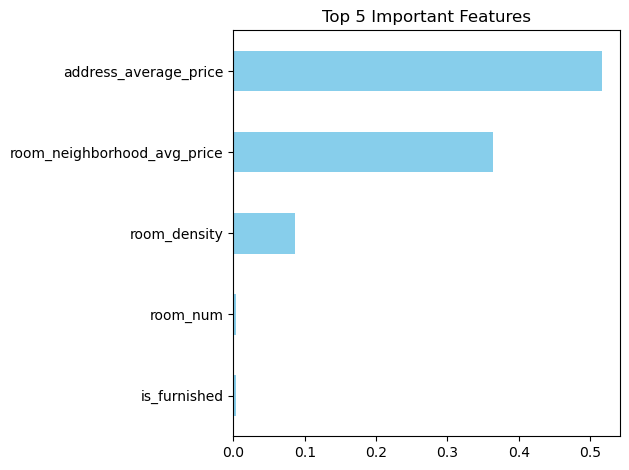

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# הכנת הדאטה
df_processed = prepare_data(df, "train")  # אם טרם בוצע

# הפרדת מטריצת מאפיינים ותגית
X = df_processed.drop("price", axis=1)
y = df_processed["price"]

# חלוקה ל־Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# רשת פרמטרים לאופטימיזציה
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# GridSearchCV עם 10-fold
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# אימון
grid_search.fit(X_train, y_train)

# שמירת המודל
best_rf = grid_search.best_estimator_
en_model1 = best_rf  # 👈 כדי שהקוד הבא ישתמש בו

print("🔧 Best Parameters:")
print(grid_search.best_params_)

# תחזיות
y_pred = en_model1.predict(X_test)
y_pred_train = en_model1.predict(X_train)

# ביצוע 10-Fold CV
cv_scores = cross_val_score(en_model1, X, y, cv=10, scoring='r2')

# תוצאות על סט בדיקה
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

# תוצאות על סט אימון
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# טבלת סיכום
results = {
    "Model": "Random Forest",
    "R2_test": r2_test,
    "RMSE_test": rmse_test,
    "MAE_test": mae_test,
    "R2_train": r2_train,
    "RMSE_train": rmse_train,
    "MAE_train": mae_train,
    "CV_R2_mean": cv_scores.mean(),
    "CV_R2_std": cv_scores.std()
}
results_df = pd.DataFrame([results])
print("\n📋 Summary Table:")
display(results_df)

# חשיבות פיצ'רים
importances = en_model1.feature_importances_
features = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\n⭐ Top 5 Most Important Features:")
print(features.head(5))

# גרף
features.head(5).plot(kind='barh', title='Top 5 Important Features', color='skyblue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<div dir="rtl">

    במקרה של הדאטה שלנו, שהוא בגודל בינוני וכולל מספר לא קטן של מאפיינים, הבחירה ב־Grid Search היא המתאימה והמדויקת ביותר לאופטימיזציית המודל. בניגוד לשיטות חיפוש אקראיות, Grid Search מאפשרת לבצע סריקה שיטתית ומלאה של כל שילוב אפשרי של פרמטרים מוגדרים מראש, ובכך מבטיחה שנמצא את השילוב האופטימלי ביותר עבור הנתונים שלנו. מכיוון שאין לנו דרך לדעת מראש אילו ערכים של עומק עץ, מספר עלים מינימלי או מספר עצים יתנו את התוצאה הטובה ביותר – השיטה הזו מבטיחה כיסוי מלא של אפשרויות, ללא השארת מרחבים ריקים באופטימיזציה. בנוסף, השימוש ב־cross-validation בתוך תהליך החיפוש הופך את התוצאות לאמינות יותר, שכן כל קומבינציה נבחנת על פני מספר תתי־מדגמים מהדאטה, ומפחיתה את הסיכון להתאמה מקרית בלבד (overfitting). לכן, בשקלול של גודל הדאטה, רמת המורכבות וסוג המודל (Random Forest), Grid Search היא הבחירה היעילה והאמינה ביותר.

</div>


<span dir="rtl" style="display:block; text-align:right;">
<strong>🔍 ניתוח תוצאות — ביצועים:</strong>
</span>

<span dir="rtl" style="display:block; text-align:right;">
- Elastic Net השיג ערך R² של כ־0.862 ו־RMSE של כ־1348 במדגם ה־test.  
- Random Forest השיג ערך R² של כ־0.866 ו־RMSE של כ־1332 במדגם ה־test.
</span>

<span dir="rtl" style="display:block; text-align:right;">
למרות שה־Random Forest הציג ביצועים מעט טובים יותר במדגם ה־test, שני המודלים סיפקו תחזיות מדויקות מאוד.  
Elastic Net היה מדויק יותר ברמות גבוהות של רגולריזציה, בעוד Random Forest שמר על עקביות טובה גם עם כמות פיצ'רים גדולה.
</span>

<span dir="rtl" style="display:block; text-align:right;">
חשוב לציין שהפרש ה־RMSE קטן, ולכן הבחירה בין המודלים צריכה להתחשב גם באפשרות לפרש את התרומה של כל משתנה.
</span>

<hr>

<span dir="rtl" style="display:block; text-align:right;">
<strong>🎯 התאמה בין המאפיינים החשובים ביותר במודלים:</strong>
</span>

<span dir="rtl" style="display:block; text-align:right;">
קיימת התאמה מובהקת בין המאפיינים החשובים ביותר בשני המודלים.  
גם Elastic Net וגם Random Forest זיהו את `address_average_price` ו־`room_neighborhood_avg_price` כמשפיעים ביותר על המחיר — מה שמצביע על כך ש**המיקום** הוא המשתנה המרכזי בקביעת שווי הדירה.
</span>

<span dir="rtl" style="display:block; text-align:right;">
Elastic Net הדגיש גם את `property_type_avg_price`, `room_density` ו־`has_garden`, אשר מצביעים על קשרים ליניאריים יחסית למחיר.
</span>

<span dir="rtl" style="display:block; text-align:right;">
לעומת זאת, Random Forest הדגיש משתנים כמו `is_furnished` ו־`room_num` — שמעידים על קשרים מורכבים יותר או ספים מסוימים, למשל: השפעת ריהוט או מספר חדרים קטן מאוד.
</span>

<hr>

<span dir="rtl" style="display:block; text-align:right;">
<strong>🔄 הבדלים ודמיון בין המודלים – והסיבות להם</strong>
</span>

<span dir="rtl" style="display:block; text-align:right;">
ההבדל המרכזי בין המודלים בא לידי ביטוי **בבחירת הפיצ'רים שנמצאו משמעותיים**:  
Elastic Net בחר משתנים עם קשר ליניארי ויציב למחיר – כמו `property_type_avg_price` וקטגוריות `room_density`.  
לעומתו, Random Forest זיהה גם משתנים שלאו דווקא משפיעים באופן ישיר, אלא **דרך אינטראקציות מורכבות או ספים** – למשל `is_furnished` או `room_num`, שמעידים על התנהגות לא ליניארית בדאטה.
</span>

<span dir="rtl" style="display:block; text-align:right;">
Elastic Net נוטה להתמקד במשתנים שקל למדוד את השפעתם בנפרד, ולכן הוא מבליט פיצ'רים בעלי תרומה עצמאית חזקה.  
Random Forest, לעומת זאת, מסוגל לגלות תרומות עקיפות או משולבות – גם אם הן חלשות בנפרד – ולכן הוא מזהה משתנים שה־Elastic Net פחות רגיש אליהם.
</span>

<span dir="rtl" style="display:block; text-align:right;">
התוצאה היא **סט שונה של פיצ'רים מדורגים**, שממחיש את אופי הפעולה השונה של כל מודל.  
Elastic Net מספק מבט ברור על תרומת משתנה יחיד, בעוד Random Forest חושף אפקטים מורכבים יותר — גם אם קשה לפרש אותם באופן ישיר.
</span>

<span dir="rtl" style="display:block; text-align:right;">
<strong>🧠 מסקנה:</strong>
</span>

<span dir="rtl" style="display:block; text-align:right;">
שני המודלים זיהו את הליבה המשותפת – מיקום הדירה – כמשפיע המרכזי על המחיר.  
Elastic Net מעניק תחזיות פרשניות המבוססות על קשרים ליניאריים, בעוד Random Forest מביא יתרון במצבים של קשרים מורכבים, אינטראקציות, ואפקטים שאינם ליניאריים.
</span>

<span dir="rtl" style="display:block; text-align:right;">
שילוב בין השניים או שימוש מושכל לפי צורך – יכול להעניק תחזית מדויקת ופרשנית גם יחד.
</span>

<hr>

<span dir="rtl" style="display:block; text-align:right;">
<strong>✅ סיכום:</strong>
</span>

<span dir="rtl" style="display:block; text-align:right;">
Elastic Net: דיוק גבוה עם R² של 0.862 ו־RMSE של 1348, כולל פרשנות ברורה.  
Random Forest: דיוק דומה מאוד עם R² של 0.866 ו־RMSE של 1332, אך פחות פרשני.
</span>

<span dir="rtl" style="display:block; text-align:right;">
שני המודלים מספקים תובנות משלימות — הבחירה ביניהם תלויה בצורך בפרשנות לעומת גמישות בקשרים.
</span>
